# Inference testing

## Module load

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`


In [2]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions

In [3]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end

sort_by_infection_time (generic function with 1 method)

## Graph generation

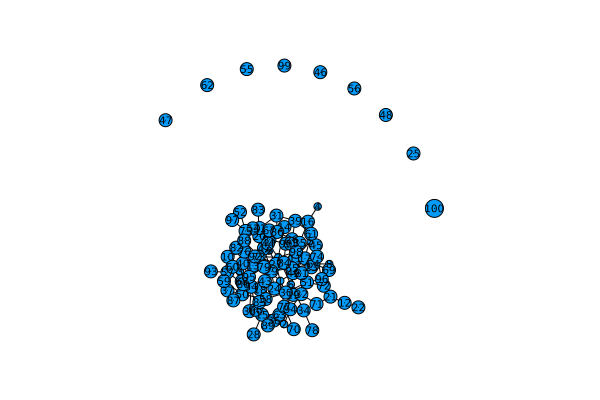

In [4]:
NV = 100 # number of graph vertices
k = 3 # average degree

# generate a random graph with NV vertices and NE edges
#G = random_regular_graph(NV, ceil(Int,k))

#genrate an Erdos-Renyi random graph with average connectivity k
G = erdos_renyi(NV, k/NV)

# generate a random tree
#G = uniform_tree(NV)

# generate a Watts-Strogatz small world random graph with average connectivity k
#G = watts_strogatz(NV, ceil(Int,k), 0.1, remove_edges = true)

# Graph plotting
display(graphplot(G, names=vertices(G), edgecolor=:black,curves=false, nodeshape=:circle, markersize =.15))

## - SIRS: model simulation

### System parameter definition and simulation

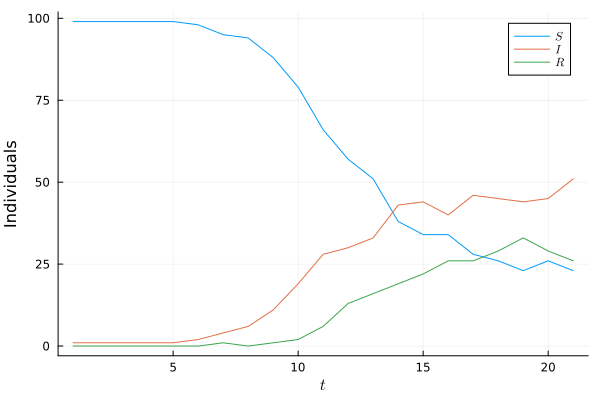

sources: [69]


In [5]:
# define the constants
T::Int = 20 # total time
fₚ::Float64 = 0.0 # false-positive rate
fₙ::Float64 = 0.0 # false-negative rate
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.4 # Infection rate
r₀::Float64 = 0.15 # Recovery rate
σ₀::Float64 = 0.15 # Immunity rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIRS(ε_autoinf, r₀, σ₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, γ=γ)
inf_tuples, invperm_sort, perm_sort = sort_by_infection_time(config, T, NV)

isource = findall(x->x==1.0, config[:,1])
println("sources: $(isource)")

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI nrR], xlabel = L"t", ylabel = "Individuals", label = [L"S" L"I" L"R"]))

### Generation of observations

In [6]:
const Nobs::Int = ceil(NV*.75) # number of observations

# generate observations
obsmat = ones(nv(G), T+1) * (-1.0)
obslist = []
for (iₗ, τₗ) in sample(collect(zip(1:NV,ones(Int, NV)*ceil(Int, T*.51))), Nobs, replace = false) 
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
    push!(obslist, (iₗ, τₗ-1))
end
    
# insert the observations into the model structure
model.obsmat .= obsmat;

In [7]:
println(obslist)

Any[(52, 10), (93, 10), (16, 10), (59, 10), (75, 10), (37, 10), (35, 10), (87, 10), (79, 10), (97, 10), (61, 10), (22, 10), (56, 10), (98, 10), (33, 10), (65, 10), (43, 10), (45, 10), (51, 10), (58, 10), (32, 10), (62, 10), (80, 10), (7, 10), (2, 10), (26, 10), (41, 10), (77, 10), (28, 10), (89, 10), (10, 10), (53, 10), (46, 10), (38, 10), (81, 10), (71, 10), (64, 10), (42, 10), (39, 10), (69, 10), (31, 10), (34, 10), (40, 10), (83, 10), (50, 10), (86, 10), (70, 10), (19, 10), (11, 10), (47, 10), (84, 10), (12, 10), (25, 10), (68, 10), (49, 10), (85, 10), (90, 10), (20, 10), (66, 10), (27, 10), (36, 10), (99, 10), (21, 10), (13, 10), (94, 10), (82, 10), (8, 10), (29, 10), (92, 10), (44, 10), (3, 10), (100, 10), (60, 10), (1, 10), (17, 10)]


## Inference SCDC -- autoinfection, $\mu$ cutoff

In [8]:
# computational constants
epsconv::Float64 = 5e-15 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.0 # damping factor
μ_cutoff::Float64 = -1

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob_sorted = zeros(NV, T+1, 3)
for inode in nodes
#    marg_prob_sorted[inode.i,:,:] .= inode.marg.m'
    marg_prob_sorted[invperm_sort[inode.i],:,:] .= inode.marg.m'
end
 #marg_prob_sorted = marg_prob_sorted[perm_sort,:,:];

i = 1 ε = 1.1495562693490675
i = 2 ε = 1.6904521155257437
i = 3 ε = 1.9327739202165404
i = 4 ε = 1.6765973891135637
i = 5 ε = 1.3620908763397814
i = 6 ε = 1.562541401422615
i = 7 ε = 1.5561586156886884
i = 

8 ε = 0.9698352683980082
i = 9 ε = 1.2365634774168348
i = 10 ε = 0.9468169136515243
i = 11 ε = 0.9970835742086074
i = 12 ε = 1.0339443800402872
i = 13 ε = 0.5526644977586573
i = 14 ε = 0.4212978883883988
i = 15 ε = 0.4776132582157755
i = 16 ε = 0.3839353942925287
i = 17 ε = 0.328608036085155
i = 18 ε = 0.2711323469614293
i = 19 ε = 0.1854766746390319
i = 20 ε = 0.1748296469611954
i = 21 ε = 0.14420780226375657
i = 22 ε = 0.10573526493939689


i = 23 ε = 0.09379175795413608
i = 24 ε = 0.0791506533536328
i = 25 ε = 0.05704603889796078
i = 26 ε = 0.05157719374505165
i = 27 ε = 0.04439918651141728
i = 28 ε = 0.03163803029350298
i = 29 ε = 0.027270519354282263
i = 30 ε = 0.02381232078260076
i = 31 ε = 0.017445026948933573
i = 32 ε = 0.015196635272795467
i = 33 ε = 0.01333298952558215
i = 34 ε = 0.009588960316397444
i = 35 ε = 0.00818830124870873
i = 36 ε = 0.007251450348019772
i = 37 ε = 0.00524300799655375
i = 38 ε = 0.0044626002414707155
i = 39 ε = 0.003981315423008169
i = 40 ε = 0.003023068783963967
i = 41 ε = 0.0024135204091283446
i = 42 ε = 0.0021644379472308684
i = 43 ε = 0.0017714893858946645
i = 44 ε = 0.0013121504224141711


i = 45 ε = 0.001242946614019802
i = 46 ε = 0.0010301400182088916
i = 47 ε = 0.0007618545787637654
i = 48 ε = 0.0007157919106938193
i = 49 ε = 0.0005967055379006991
i = 50 ε = 0.0004404107477349317
i = 51 ε = 0.00041043424951869856
i = 52 ε = 0.0003438948030777267
i = 53 ε = 0.0002533947858276431
i = 54 ε = 0.00023433854371057716
i = 55 ε = 0.00019735747196947262
i = 56 ε = 0.00014517074786368767
i = 57 ε = 0.0001332590525242594
i = 58 ε = 0.00011277642393436871
i = 59 ε = 8.282313539453856e-5
i = 60 ε = 7.547431060572762e-5
i = 61 ε = 6.418153468257248e-5
i = 62 ε = 4.7060048449232283e-5
i = 63 ε = 4.257974764321215e-5
i = 64 ε = 3.6380181935968814e-5
i = 65 ε = 2.6633939693487818e-5
i = 

66 ε = 2.3927611709662067e-5
i = 67 ε = 2.05401917680037e-5
i = 68 ε = 1.501434925521572e-5
i = 69 ε = 1.3393487829138628e-5
i = 70 ε = 1.155163313082408e-5
i = 71 ε = 8.43099538394565e-6
i = 72 ε = 7.467240462633029e-6
i = 73 ε = 6.471067212188153e-6
i = 74 ε = 4.7156395075464985e-6
i = 75 ε = 4.146406598515284e-6
i = 76 ε = 3.6106941090352507e-6
i = 77 ε = 2.6270850129739287e-6
i = 78 ε = 2.292860088459747e-6
i = 79 ε = 2.006571654056266e-6
i = 80 ε = 1.4576111568853634e-6
i = 81 ε = 1.26245271447889e-6
i = 82 ε = 1.110518776381575e-6
i = 83 ε = 8.053689511955398e-7
i = 84 ε = 6.9198914498525e-7
i = 85 ε = 6.119857905995119e-7
i = 86 ε = 4.4306043178732324e-7


i = 87 ε = 3.7750760895072233e-7
i = 88 ε = 3.357556657146432e-7
i = 89 ε = 2.4852632996008595e-7
i = 90 ε = 2.04909069045911e-7
i = 91 ε = 1.8334516871387763e-7
i = 92 ε = 1.4568986672625073e-7
i = 93 ε = 1.1062234051006925e-7
i = 94 ε = 1.0270942873980005e-7
i = 95 ε = 8.49479639963846e-8
i = 96 ε = 6.286352327578015e-8
i = 97 ε = 5.925405033302411e-8
i = 98 ε = 4.9283309322412094e-8
i = 99 ε = 3.6401962000276455e-8
i = 100 ε = 3.403372661470172e-8
i = 101 ε = 2.8458529865993398e-8
i = 102 ε = 2.0982182102891045e-8
i = 103 ε = 1.946464633917344e-8
i = 104 ε = 1.635955138024059e-8
i = 105 ε = 1.2042158159530914e-8
i = 106 ε = 1.1086484508204819e-8
i = 107 ε = 9.364112152354664e-9
i = 108 ε = 6.880906400219544e-9


i = 109 ε = 6.289285092719865e-9
i = 110 ε = 5.338003816746095e-9
i = 111 ε = 3.916638235956782e-9
i = 112 ε = 3.553739413852952e-9
i = 113 ε = 3.0305831177912523e-9
i = 114 ε = 2.2197426119419106e-9
i = 115 ε = 2.0001368339350734e-9
i = 116 ε = 1.7137292696034478e-9
i = 117 ε = 1.2533613036325164e-9
i = 118 ε = 1.1215358641791795e-9
i = 119 ε = 9.653887689253793e-10
i = 120 ε = 7.059386408769797e-10
i = 121 ε = 6.260546525638233e-10
i = 122 ε = 5.413659520669967e-10
i = 123 ε = 3.9411296448577104e-10
i = 124 ε = 3.4830704986887895e-10
i = 125 ε = 3.028157724571656e-10
i = 126 ε = 2.207330984660416e-10
i = 127 ε = 1.9281798380177406e-10
i = 128 ε = 1.6836487759519514e-10
i = 129 ε = 1.2277334704435816e-10
i = 130 ε = 1.0634093605688122e-10


i = 131 ε = 9.334288897377974e-11
i = 132 ε = 6.794609319626943e-11
i = 133 ε = 5.835909533402628e-11
i = 134 ε = 5.1501580777824074e-11
i = 135 ε = 3.744471399613758e-11
i = 136 ε = 3.188926900321576e-11
i = 137 ε = 2.8297697518553377e-11
i = 138 ε = 2.053268666202257e-11
i = 139 ε = 1.732558541078788e-11
i = 140 ε = 1.5464185487701343e-11
i = 141 ε = 1.1971312829928138e-11
i = 142 ε = 9.37550037605206e-12
i = 143 ε = 8.473777235451507e-12
i = 144 ε = 6.996958568095124e-12
i = 145 ε = 5.201283848066396e-12
i = 146 ε = 4.89341900333784e-12
i = 147 ε = 4.0605296902640475e-12
i = 148 ε = 3.0180302701410255e-12
i = 149 ε = 2.8211877278749853e-12
i = 150 ε = 2.357336548186595e-12
i = 151 ε = 1.7490453529944716e-12
i = 152 ε = 1.6230350396995163e-12


i = 153 ε = 1.3626877404249171e-12
i = 154 ε = 1.006528194125167e-12
i = 155 ε = 9.268141809570807e-13
i = 156 ε = 7.799316747991725e-13
i = 157 ε = 5.939693181744587e-13
i = 158 ε = 5.229150445984487e-13
i = 159 ε = 4.425348976155874e-13
i = 160 ε = 3.218536548388329e-13
i = 161 ε = 2.893241202173158e-13
i = 162 ε = 2.4658053376924727e-13
i = 163 ε = 1.8818280267396403e-13
i = 164 ε = 1.724176357242868e-13
i = 165 ε = 1.4566126083082054e-13
i = 166 ε = 1.0413891970983968e-13
i = 167 ε = 1.290079154614432e-13
i = 168 ε = 7.827072323607354e-14
i = 169 ε = 5.850875339774575e-14
i = 170 ε = 5.284661597215745e-14
i = 171 ε = 4.5630166312093934e-14
i = 172 ε = 3.108624468950438e-14
i = 173 ε = 2.4313884239290928e-14
i = 174 ε = 2.1649348980190553e-14


i = 175 ε = 1.3350431871117507e-14
i = 176 ε = 1.354472090042691e-14
i = 177 ε = 9.325873406851315e-15
i = 178 ε = 8.548717289613705e-15
i = 179 ε = 4.773959005888173e-15
Converged after 179 iterations


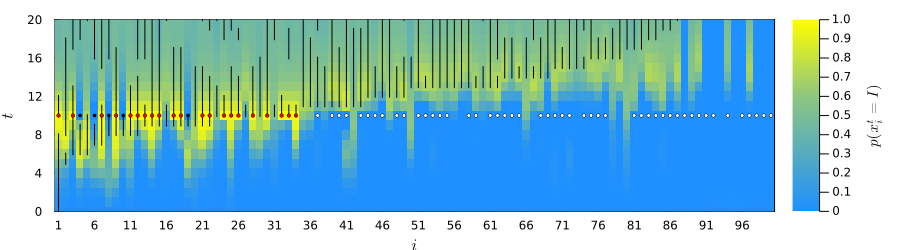

In [9]:
resize_factor = 1.0

cg = cgrad([:dodgerblue, :yellow], 0.6)

plI = heatmap(1:NV, 0:T, marg_prob_sorted[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

cols = [:white, :red, :black]
for (i,t) in obslist
    scatter!(plI, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

plot!(plI, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

display(plI)

## Inference -- no autoinfection, no $\mu$ cutoff

In [10]:
# computational constants
μ_cutoff::Float64 = -Inf
ε_autoinf::Float64 = 0.0

model.Disease.εᵢᵗ .*= ε_autoinf 

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob_sorted = zeros(NV, T+1, 3)
for inode in nodes
    marg_prob_sorted[invperm_sort[inode.i],:,:] .= inode.marg.m'
end

i = 1 ε = 129.62278472753297
i = 2 ε = 391.36293139737353
i = 3 ε = 114.46150346293672
i = 4 ε = 223.60171565573512
i = 5 ε = 212.04138490607477
i = 6 ε = 571.7623243949178
i = 7 ε = NaN
i = 8 ε = NaN
i = 9 ε = NaN
i = 10 ε = NaN
i = 11 ε = NaN
i = 12 ε = NaN
i = 13 ε = NaN
i = 14 ε = NaN
i = 15 ε = NaN
i = 16 ε = NaN
i = 17 ε = NaN
i = 18 ε = NaN
i = 19 ε = NaN
i = 

20 ε = NaN
i = 21 ε = NaN
i = 22 ε = NaN
i = 23 ε = NaN
i = 24 ε = NaN
i = 25 ε = NaN
i = 26 ε = NaN
i = 27 ε = NaN
i = 28 ε = NaN
i = 29 ε = NaN
i = 30 ε = NaN
i = 31 ε = NaN
i = 32 ε = NaN
i = 33 ε = NaN
i = 34 ε = NaN
i = 35 ε = NaN
i = 36 ε = NaN
i = 37 ε = NaN
i = 38 ε = NaN
i = 39 ε = NaN
i = 40 ε = NaN
i = 41 ε = NaN
i = 42 ε = NaN
i = 43 ε = NaN
i = 

44 ε = NaN
i = 45 ε = NaN
i = 46 ε = NaN
i = 47 ε = NaN
i = 48 ε = NaN
i = 49 ε = NaN
i = 50 ε = NaN
i = 51 ε = NaN
i = 52 ε = NaN
i = 53 ε = NaN
i = 54 ε = NaN
i = 55 ε = NaN
i = 56 ε = NaN
i = 57 ε = NaN
i = 58 ε = NaN
i = 59 ε = NaN
i = 60 ε = NaN
i = 61 ε = NaN
i = 62 ε = NaN
i = 63 ε = NaN
i = 64 ε = NaN
i = 65 ε = NaN
i = 66 ε = NaN
i = 67 ε = NaN
i = 

68 ε = NaN
i = 69 ε = NaN
i = 70 ε = NaN
i = 71 ε = NaN
i = 72 ε = NaN
i = 73 ε = NaN
i = 74 ε = NaN
i = 75 ε = NaN
i = 76 ε = NaN
i = 77 ε = NaN
i = 78 ε = NaN
i = 79 ε = NaN
i = 80 ε = NaN
i = 81 ε = NaN
i = 82 ε = NaN
i = 83 ε = NaN
i = 84 ε = NaN
i = 85 ε = NaN
i = 86 ε = NaN
i = 87 ε = NaN
i = 88 ε = NaN
i = 89 ε = NaN
i = 90 ε = NaN
i = 91 ε = NaN
i = 

92 ε = NaN
i = 93 ε = NaN
i = 94 ε = NaN
i = 95 ε = NaN
i = 96 ε = NaN
i = 97 ε = NaN
i = 98 ε = NaN
i = 99 ε = NaN
i = 100 ε = NaN
i = 101 ε = NaN
i = 102 ε = NaN
i = 103 ε = NaN
i = 104 ε = NaN
i = 105 ε = NaN
i = 106 ε = NaN
i = 107 ε = NaN
i = 108 ε = NaN
i = 109 ε = NaN
i = 110 ε = NaN
i = 111 ε = NaN
i = 112 ε = NaN
i = 113 ε = NaN
i = 114 ε = NaN
i = 115 ε = NaN
i = 

116 ε = NaN
i = 117 ε = NaN
i = 118 ε = NaN
i = 119 ε = NaN
i = 120 ε = NaN
i = 121 ε = NaN
i = 122 ε = NaN
i = 123 ε = NaN
i = 124 ε = NaN
i = 125 ε = NaN
i = 126 ε = NaN
i = 127 ε = NaN
i = 128 ε = NaN
i = 129 ε = NaN
i = 130 ε = NaN
i = 131 ε = NaN
i = 132 ε = NaN
i = 133 ε = NaN
i = 134 ε = NaN
i = 135 ε = NaN
i = 136 ε = NaN
i = 137 ε = NaN
i = 138 ε = NaN
i = 139 ε = NaN
i = 140 ε = NaN


i = 141 ε = NaN
i = 142 ε = NaN
i = 143 ε = NaN
i = 144 ε = NaN
i = 145 ε = NaN
i = 146 ε = NaN
i = 147 ε = NaN
i = 148 ε = NaN
i = 149 ε = NaN
i = 150 ε = NaN
i = 151 ε = NaN
i = 152 ε = NaN
i = 153 ε = NaN
i = 154 ε = NaN
i = 155 ε = NaN
i = 156 ε = NaN
i = 157 ε = NaN
i = 158 ε = NaN
i = 159 ε = NaN
i = 160 ε = NaN
i = 161 ε = NaN
i = 162 ε = NaN
i = 163 ε = NaN
i = 164 ε = NaN
i = 165 ε = NaN
i = 

166 ε = NaN
i = 167 ε = NaN
i = 168 ε = NaN
i = 169 ε = NaN
i = 170 ε = NaN
i = 171 ε = NaN
i = 172 ε = NaN
i = 173 ε = NaN
i = 174 ε = NaN
i = 175 ε = NaN
i = 176 ε = NaN
i = 177 ε = NaN
i = 178 ε = NaN
i = 179 ε = NaN
i = 180 ε = NaN
i = 181 ε = NaN
i = 182 ε = NaN
i = 183 ε = NaN
i = 184 ε = NaN
i = 185 ε = NaN
i = 186 ε = NaN
i = 187 ε = NaN
i = 188 ε = NaN
i = 189 ε = NaN
i = 

190 ε = NaN
i = 191 ε = NaN
i = 192 ε = NaN
i = 193 ε = NaN
i = 194 ε = NaN
i = 195 ε = NaN
i = 196 ε = NaN
i = 197 ε = NaN
i = 198 ε = NaN
i = 199 ε = NaN
i = 200 ε = NaN
i = 201 ε = NaN
i = 202 ε = NaN
i = 203 ε = NaN
i = 204 ε = NaN
i = 205 ε = NaN
i = 206 ε = NaN
i = 207 ε = NaN
i = 208 ε = NaN
i = 209 ε = NaN
i = 210 ε = NaN
i = 211 ε = NaN
i = 212 ε = NaN


i = 213 ε = NaN
i = 214 ε = NaN
i = 215 ε = NaN
i = 216 ε = NaN
i = 217 ε = NaN
i = 218 ε = NaN
i = 219 ε = NaN
i = 220 ε = NaN
i = 221 ε = NaN
i = 222 ε = NaN
i = 223 ε = NaN
i = 224 ε = NaN
i = 225 ε = NaN
i = 226 ε = NaN
i = 227 ε = NaN
i = 228 ε = NaN
i = 229 ε = NaN
i = 230 ε = NaN
i = 231 ε = NaN
i = 232 ε = NaN
i = 233 ε = NaN
i = 234 ε = NaN
i = 235 ε = NaN
i = 236 ε = NaN
i = 237 ε = NaN
i = 

238 ε = NaN
i = 239 ε = NaN
i = 240 ε = NaN
i = 241 ε = NaN
i = 242 ε = NaN
i = 243 ε = NaN
i = 244 ε = NaN
i = 245 ε = NaN
i = 246 ε = NaN
i = 247 ε = NaN
i = 248 ε = NaN
i = 249 ε = NaN
i = 250 ε = NaN
i = 251 ε = NaN
i = 252 ε = NaN
i = 253 ε = NaN
i = 254 ε = NaN
i = 255 ε = NaN
i = 256 ε = NaN
i = 257 ε = NaN
i = 258 ε = NaN
i = 259 ε = NaN
i = 260 ε = NaN
i = 261 ε = NaN
i = 262 ε = NaN


i = 263 ε = NaN
i = 264 ε = NaN
i = 265 ε = NaN
i = 266 ε = NaN
i = 267 ε = NaN
i = 268 ε = NaN
i = 269 ε = NaN
i = 270 ε = NaN
i = 271 ε = NaN
i = 272 ε = NaN
i = 273 ε = NaN
i = 274 ε = NaN
i = 275 ε = NaN
i = 276 ε = NaN
i = 277 ε = NaN
i = 278 ε = NaN
i = 279 ε = NaN
i = 280 ε = NaN
i = 281 ε = NaN
i = 282 ε = NaN
i = 283 ε = NaN
i = 284 ε = NaN
i = 285 ε = NaN
i = 286 ε = NaN


i = 287 ε = NaN
i = 288 ε = NaN
i = 289 ε = NaN
i = 290 ε = NaN
i = 291 ε = NaN
i = 292 ε = NaN
i = 293 ε = NaN
i = 294 ε = NaN
i = 295 ε = NaN
i = 296 ε = NaN
i = 297 ε = NaN
i = 298 ε = NaN
i = 299 ε = NaN
i = 300 ε = NaN
i = 301 ε = NaN
i = 302 ε = NaN
i = 303 ε = NaN
i = 304 ε = NaN
i = 305 ε = NaN
i = 306 ε = NaN
i = 307 ε = NaN
i = 308 ε = NaN
i = 309 ε = NaN
i = 310 ε = NaN


i = 311 ε = NaN
i = 312 ε = NaN
i = 313 ε = NaN
i = 314 ε = NaN
i = 315 ε = NaN
i = 316 ε = NaN
i = 317 ε = NaN
i = 318 ε = NaN
i = 319 ε = NaN
i = 320 ε = NaN
i = 321 ε = NaN
i = 322 ε = NaN
i = 323 ε = NaN
i = 324 ε = NaN
i = 325 ε = NaN
i = 326 ε = NaN
i = 327 ε = NaN
i = 328 ε = NaN
i = 329 ε = NaN
i = 330 ε = NaN
i = 331 ε = NaN
i = 332 ε = NaN
i = 333 ε = NaN
i = 334 ε = NaN


i = 335 ε = NaN
i = 336 ε = NaN
i = 337 ε = NaN
i = 338 ε = NaN
i = 339 ε = NaN
i = 340 ε = NaN
i = 341 ε = NaN
i = 342 ε = NaN
i = 343 ε = NaN
i = 344 ε = NaN
i = 345 ε = NaN
i = 346 ε = NaN
i = 347 ε = NaN
i = 348 ε = NaN
i = 349 ε = NaN
i = 350 ε = NaN
i = 351 ε = NaN
i = 352 ε = NaN
i = 353 ε = NaN
i = 354 ε = NaN
i = 355 ε = NaN
i = 356 ε = NaN
i = 357 ε = NaN
i = 358 ε = NaN
i = 359 ε = NaN
i = 

360 ε = NaN
i = 361 ε = NaN
i = 362 ε = NaN
i = 363 ε = NaN
i = 364 ε = NaN
i = 365 ε = NaN
i = 366 ε = NaN
i = 367 ε = NaN
i = 368 ε = NaN
i = 369 ε = NaN
i = 370 ε = NaN
i = 371 ε = NaN
i = 372 ε = NaN
i = 373 ε = NaN
i = 374 ε = NaN
i = 375 ε = NaN
i = 376 ε = NaN
i = 377 ε = NaN
i = 378 ε = NaN
i = 379 ε = NaN
i = 380 ε = NaN
i = 381 ε = NaN
i = 382 ε = NaN
i = 383 ε = NaN
i = 

384 ε = NaN
i = 385 ε = NaN
i = 386 ε = NaN
i = 387 ε = NaN
i = 388 ε = NaN
i = 389 ε = NaN
i = 390 ε = NaN
i = 391 ε = NaN
i = 392 ε = NaN
i = 393 ε = NaN
i = 394 ε = NaN
i = 395 ε = NaN
i = 396 ε = NaN
i = 397 ε = NaN
i = 398 ε = NaN
i = 399 ε = NaN
i = 400 ε = NaN
i = 401 ε = NaN
i = 402 ε = NaN
i = 403 ε = NaN
i = 404 ε = NaN


i = 405 ε = NaN
i = 406 ε = NaN
i = 407 ε = NaN
i = 408 ε = NaN
i = 409 ε = NaN
i = 410 ε = NaN
i = 411 ε = NaN
i = 412 ε = NaN
i = 413 ε = NaN
i = 414 ε = NaN
i = 415 ε = NaN
i = 416 ε = NaN
i = 417 ε = NaN
i = 418 ε = NaN
i = 419 ε = NaN
i = 420 ε = NaN
i = 421 ε = NaN
i = 422 ε = NaN
i = 423 ε = NaN
i = 424 ε = NaN
i = 425 ε = NaN
i = 426 ε = NaN
i = 427 ε = NaN
i = 428 ε = NaN
i = 429 ε = NaN
i = 

430 ε = NaN
i = 431 ε = NaN
i = 432 ε = NaN
i = 433 ε = NaN
i = 434 ε = NaN
i = 435 ε = NaN
i = 436 ε = NaN
i = 437 ε = NaN
i = 438 ε = NaN
i = 439 ε = NaN
i = 440 ε = NaN
i = 441 ε = NaN
i = 442 ε = NaN
i = 443 ε = NaN
i = 444 ε = NaN
i = 445 ε = NaN
i = 446 ε = NaN
i = 447 ε = NaN
i = 448 ε = NaN
i = 449 ε = NaN
i = 450 ε = NaN


i = 451 ε = NaN
i = 452 ε = NaN
i = 453 ε = NaN
i = 454 ε = NaN
i = 455 ε = NaN
i = 456 ε = NaN
i = 457 ε = NaN
i = 458 ε = NaN
i = 459 ε = NaN
i = 460 ε = NaN
i = 461 ε = NaN
i = 462 ε = NaN
i = 463 ε = NaN
i = 464 ε = NaN
i = 465 ε = NaN
i = 466 ε = NaN
i = 467 ε = NaN
i = 468 ε = NaN
i = 469 ε = NaN
i = 470 ε = NaN
i = 471 ε = NaN
i = 472 ε = NaN
i = 473 ε = NaN
i = 474 ε = NaN
i = 475 ε = NaN
i = 

476 ε = NaN
i = 477 ε = NaN
i = 478 ε = NaN
i = 479 ε = NaN
i = 480 ε = NaN
i = 481 ε = NaN
i = 482 ε = NaN
i = 483 ε = NaN
i = 484 ε = NaN
i = 485 ε = NaN
i = 486 ε = NaN
i = 487 ε = NaN
i = 488 ε = NaN
i = 489 ε = NaN
i = 490 ε = NaN
i = 491 ε = NaN
i = 492 ε = NaN
i = 493 ε = NaN
i = 494 ε = NaN
i = 495 ε = NaN
i = 496 ε = NaN
i = 497 ε = NaN
i = 498 ε = NaN
i = 499 ε = NaN
i = 500 ε = NaN


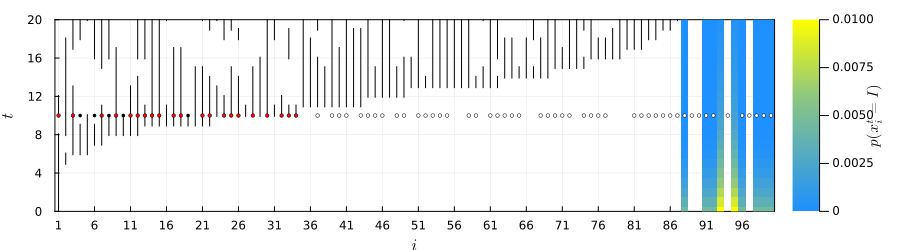

In [11]:
resize_factor = 1.0

cg = cgrad([:dodgerblue, :yellow], 0.6)

plI = heatmap(1:NV, 0:T, marg_prob_sorted[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

cols = [:white, :red, :black]
for (i,t) in obslist
    scatter!(plI, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

plot!(plI, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

display(plI)